# SHAP (SHapley Additive exPlanations) Implementation by Hand

This notebook demonstrates a simplified implementation of the SHAP algorithm from scratch. SHAP is a technique used to explain the predictions of any machine learning model by assigning each feature an importance value for a particular prediction.

## What is SHAP?

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. It connects game theory with local explanations, representing the only possible consistent and locally accurate additive feature attribution method based on expectations.

Key characteristics of SHAP:
- **Unified**: Combines various explanation methods
- **Theoretically Sound**: Based on Shapley values from cooperative game theory
- **Locally Accurate**: Provides precise explanations for individual predictions
- **Model-agnostic**: Can be applied to any machine learning model

## How SHAP Works

SHAP values are based on the concept of Shapley values from cooperative game theory. The idea is to fairly distribute the "payout" (the prediction) among the "players" (the features).

The process involves:
1. Consider all possible combinations of features (coalitions)
2. For each coalition, calculate the model's prediction
3. Determine each feature's contribution by calculating how the prediction changes when the feature is included vs. excluded
4. Average these contributions across all possible coalitions, weighted by coalition size

Let's implement this step by step!


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt


## Sigmoid Function

We'll use a sigmoid function for our example model. The sigmoid function maps any real value to a value between 0 and 1, making it useful for binary classification problems.

The formula for the sigmoid function is:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

This function has an S-shaped curve and is often used as an activation function in neural networks and logistic regression.


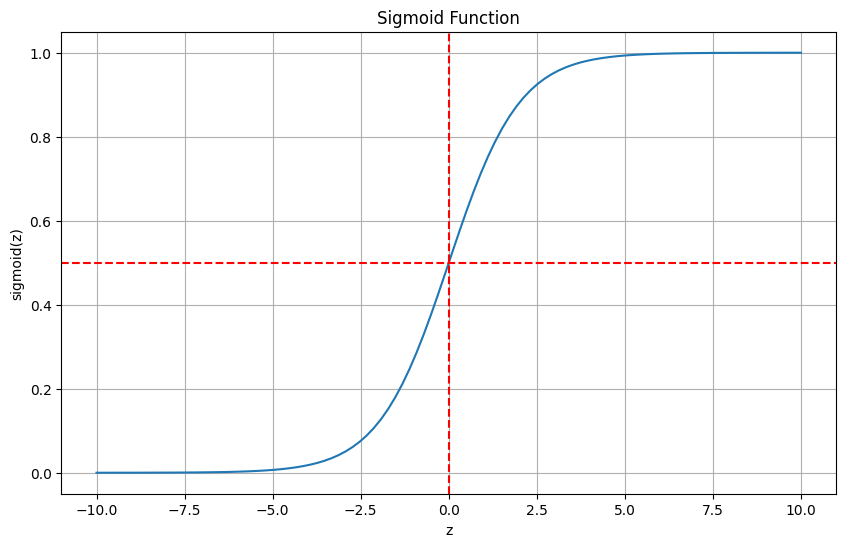

In [2]:
def sigmoid(z):
    """Convert input to a value between 0 and 1 using the sigmoid function"""
    return 1.0 / (1.0 + np.exp(-z))

# Visualize the sigmoid function
z = np.linspace(-10, 10, 100)
y = sigmoid(z)

plt.figure(figsize=(10, 6))
plt.plot(z, y)
plt.title('Sigmoid Function')
plt.xlabel('z')
plt.ylabel('sigmoid(z)')
plt.grid(True)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()


## Creating a Simple Black-Box Model

For demonstration purposes, we'll create a simple model that takes two input features (x1 and x2) and returns a probability using the sigmoid function. In a real-world scenario, this could be a complex neural network or any other black-box model.

Our model will compute: $z = 1.5 \times x_1 - 1.0 \times x_2$ and then apply the sigmoid function to get the output.

Note that the coefficients (1.5 and -1.0) represent the true importance of each feature. In a real scenario, we wouldn't know these values and would use SHAP to approximate them.


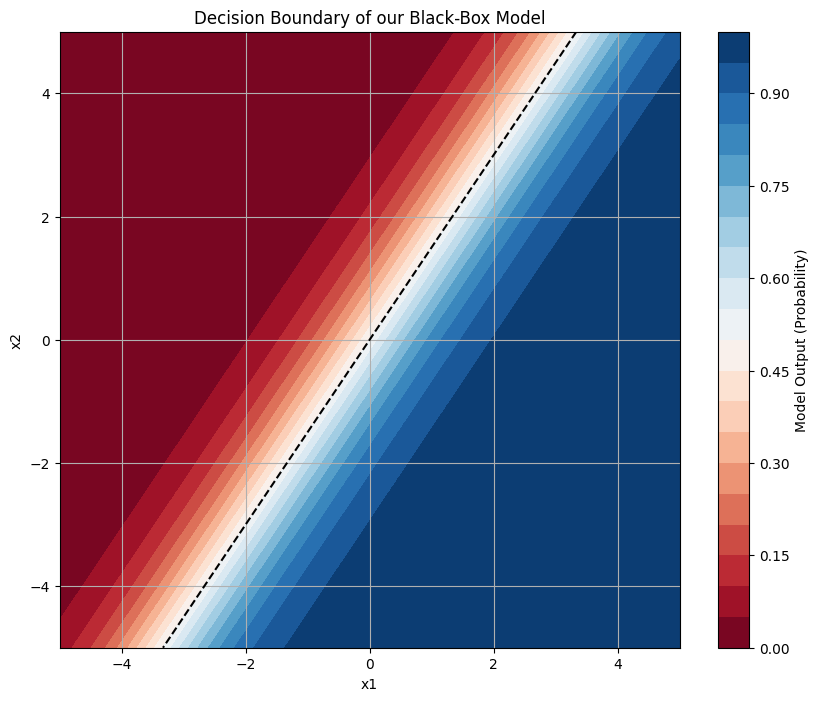

In [3]:
def my_model(x1, x2):
    """A simple model that combines two features and applies sigmoid"""
    z = 1.5 * x1 - 1.0 * x2
    return sigmoid(z)

# Let's visualize our model's decision boundary
x1_range = np.linspace(-5, 5, 100)
x2_range = np.linspace(-5, 5, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = np.zeros_like(X1)

for i in range(len(x1_range)):
    for j in range(len(x2_range)):
        Z[j, i] = my_model(X1[j, i], X2[j, i])

plt.figure(figsize=(10, 8))
contour = plt.contourf(X1, X2, Z, 20, cmap='RdBu')
plt.colorbar(contour, label='Model Output (Probability)')
plt.title('Decision Boundary of our Black-Box Model')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid(True)

# Add the decision boundary line (where output = 0.5)
plt.contour(X1, X2, Z, levels=[0.5], colors='k', linestyles='--')
plt.show()


## SHAP Implementation

Now, let's implement the SHAP algorithm from scratch. Our `SHAPHandExplainer` class will:

1. Take a black-box model as input
2. Calculate the model's prediction for the instance we want to explain
3. Calculate the model's prediction for a baseline instance (typically zeros or dataset means)
4. Calculate the model's predictions for all possible combinations of features
5. Compute the Shapley values for each feature

For a model with two features, there are 2^2 = 4 possible combinations:
- Neither feature (empty set): Use baseline values for both features
- Only x1: Use the instance value for x1 and baseline value for x2
- Only x2: Use the instance value for x2 and baseline value for x1
- Both x1 and x2: Use the instance values for both features

The Shapley value for a feature is calculated as the weighted average of its marginal contributions across all possible feature coalitions.


In [4]:
class SHAPHandExplainer(object):
    def __init__(self, model):
        """Initialize the SHAP explainer with a black-box model
        
        Args:
            model: The black-box model to explain
        """
        self.model = model
        
    def explain_instance(self, x1_0, x2_0, baseline_x1=0.0, baseline_x2=0.0):
        """Explain a specific instance by calculating Shapley values
        
        Args:
            x1_0, x2_0: The instance to explain
            baseline_x1, baseline_x2: Baseline values (typically zeros or dataset means)
            
        Returns:
            Dictionary containing Shapley values and related information
        """
        # Calculate model predictions for all possible feature combinations
        f_instance = self.model(x1_0, x2_0)  # Both features (original instance)
        f_baseline = self.model(baseline_x1, baseline_x2)  # No features (baseline)
        f_empty = self.model(baseline_x1, baseline_x2)  # Same as f_baseline
        f_x1 = self.model(x1_0, baseline_x2)  # Only x1
        f_x2 = self.model(baseline_x1, x2_0)  # Only x2
        f_x1x2 = self.model(x1_0, x2_0)  # Both features (same as f_instance)
        
        # Calculate Shapley values
        # For x1: Average of (contribution when added to empty set) and (contribution when added to {x2})
        phi_x1 = 0.5 * ((f_x1 - f_empty) + (f_x1x2 - f_x2))
        
        # For x2: Average of (contribution when added to empty set) and (contribution when added to {x1})
        phi_x2 = 0.5 * ((f_x2 - f_empty) + (f_x1x2 - f_x1))
        
        # Verify that baseline + phi_x1 + phi_x2 = f_instance (local accuracy property)
        check_sum = f_empty + phi_x1 + phi_x2
        
        return {
            "phi_x1": phi_x1,
            "phi_x2": phi_x2,
            "f_instance": f_instance,
            "f_baseline": f_baseline,
            "check_sum": check_sum
        }


## Using SHAP to Explain a Prediction

Now, let's use our SHAP implementation to explain a specific prediction. We'll:

1. Choose an instance to explain (x1=2.0, x2=0.0)
2. Set baseline values (x1=0.0, x2=0.0)
3. Calculate the Shapley values for each feature
4. Verify the local accuracy property (baseline + sum of Shapley values = model prediction)

The Shapley values will tell us how each feature contributes to the prediction. A positive value means the feature increases the prediction relative to the baseline, while a negative value means it decreases the prediction.


In [5]:
# Create a SHAP explainer with our model
explainer = SHAPHandExplainer(model=my_model)

# Choose an instance to explain
x1_0, x2_0 = 2.0, 0.0
baseline_x1, baseline_x2 = 0.0, 0.0

# Use SHAP to explain this prediction
explanation = explainer.explain_instance(x1_0, x2_0,
                                         baseline_x1,
                                         baseline_x2)

# Extract the results
f_instance = explanation["f_instance"]
f_baseline = explanation["f_baseline"]
phi_x1 = explanation["phi_x1"]
phi_x2 = explanation["phi_x2"]
check_sum = explanation["check_sum"]

# Print the results
print(f"Instance: ({x1_0},{x2_0}) => f={f_instance:.3f}")
print(f"Baseline: ({baseline_x1},{baseline_x2}) => f={f_baseline:.3f}\n")
print(f"Shapley values:")
print(f"  phi_x1 = {phi_x1:.3f}")
print(f"  phi_x2 = {phi_x2:.3f}")
print(f"\nCheck => baseline + phi_x1 + phi_x2 = {check_sum:.3f}")
print(f"Model prediction for instance       = {f_instance:.3f}")


Instance: (2.0,0.0) => f=0.953
Baseline: (0.0,0.0) => f=0.500

Shapley values:
  phi_x1 = 0.453
  phi_x2 = 0.000

Check => baseline + phi_x1 + phi_x2 = 0.953
Model prediction for instance       = 0.953


## Visualizing the SHAP Explanation

Let's visualize the SHAP explanation to better understand how it works. We'll:

1. Create a waterfall plot showing how each feature contributes to the prediction
2. Explore how Shapley values change for different instances
3. Compare the true feature importance (coefficients in our model) with the calculated Shapley values


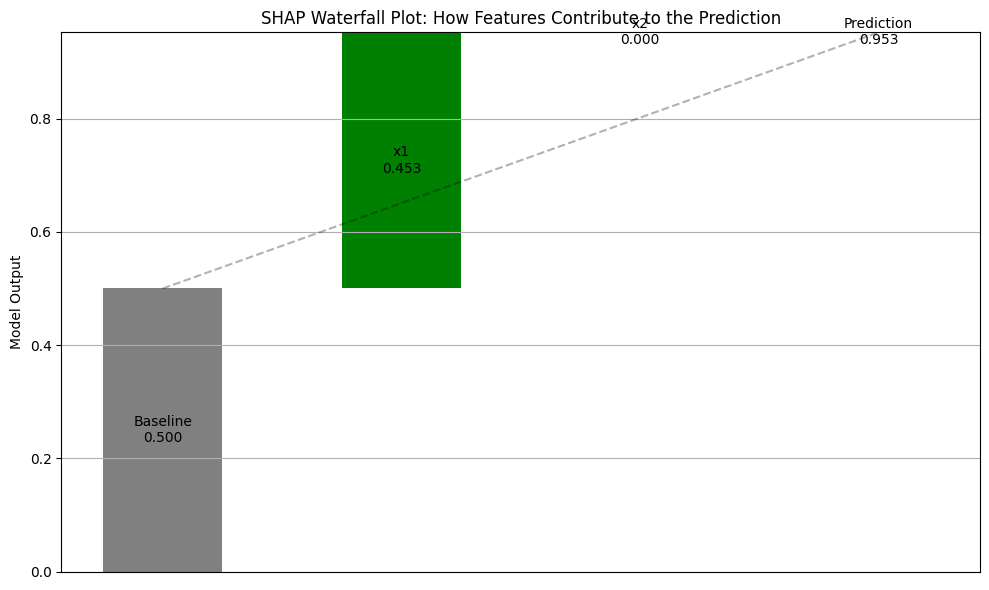

In [6]:
# Create a waterfall plot
def create_waterfall_plot(baseline, phi_values, feature_names, prediction):
    """Create a waterfall plot showing how features contribute to the prediction"""
    plt.figure(figsize=(10, 6))
    
    # Start with the baseline
    cumulative = baseline
    plt.bar(0, baseline, color='gray', width=0.5)
    plt.text(0, baseline/2, f"Baseline\n{baseline:.3f}", ha='center', va='center')
    
    # Add each feature's contribution
    for i, (phi, name) in enumerate(zip(phi_values, feature_names)):
        plt.bar(i+1, phi, bottom=cumulative, color='green' if phi > 0 else 'red', width=0.5)
        plt.text(i+1, cumulative + phi/2, f"{name}\n{phi:.3f}", ha='center', va='center')
        cumulative += phi
    
    # Add the final prediction
    plt.bar(len(phi_values)+1, 0, bottom=cumulative, color='blue', width=0.5)
    plt.text(len(phi_values)+1, cumulative, f"Prediction\n{prediction:.3f}", ha='center', va='center')
    
    # Add connecting lines
    plt.plot([0, len(phi_values)+1], [baseline, cumulative], 'k--', alpha=0.3)
    
    plt.xticks([])
    plt.ylabel('Model Output')
    plt.title('SHAP Waterfall Plot: How Features Contribute to the Prediction')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# Create the waterfall plot for our example
create_waterfall_plot(
    baseline=f_baseline,
    phi_values=[phi_x1, phi_x2],
    feature_names=['x1', 'x2'],
    prediction=f_instance
)


## Exploring SHAP Values for Different Instances

Let's explore how SHAP values change for different instances. We'll calculate and visualize SHAP values for a grid of points in our feature space.


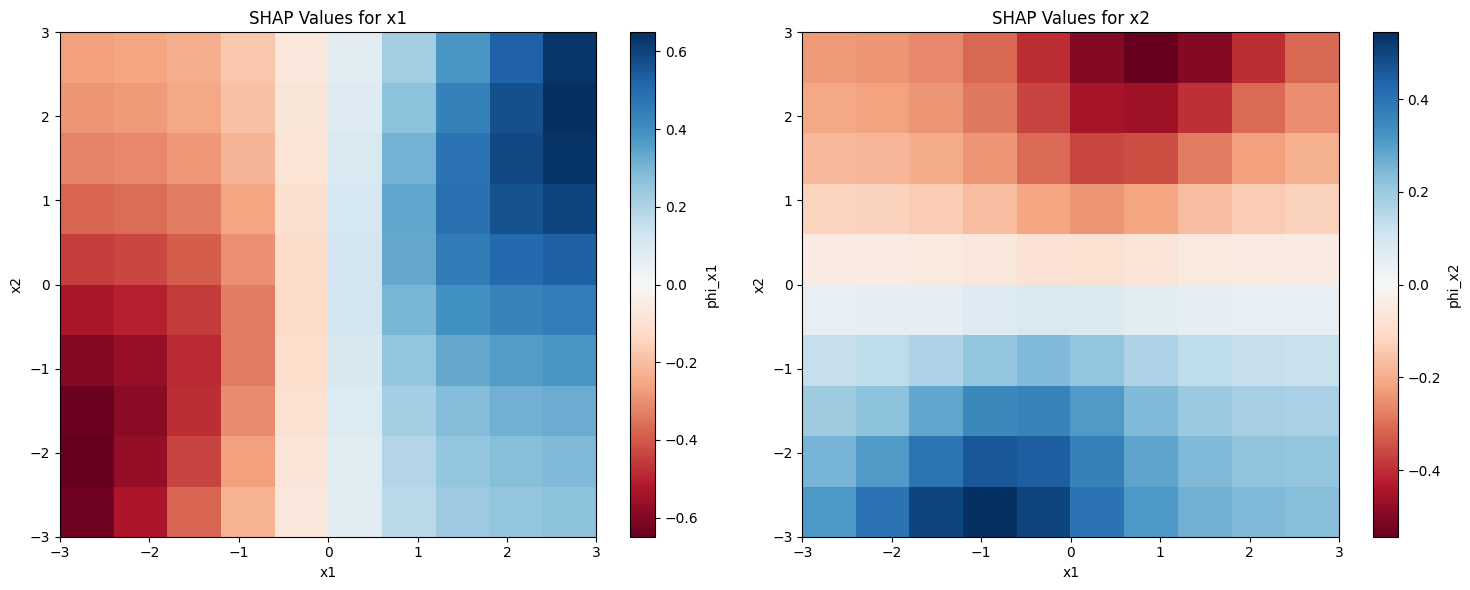

In [7]:
# Calculate SHAP values for a grid of points
grid_size = 10
x1_grid = np.linspace(-3, 3, grid_size)
x2_grid = np.linspace(-3, 3, grid_size)
phi_x1_grid = np.zeros((grid_size, grid_size))
phi_x2_grid = np.zeros((grid_size, grid_size))

for i, x1 in enumerate(x1_grid):
    for j, x2 in enumerate(x2_grid):
        explanation = explainer.explain_instance(x1, x2, 0.0, 0.0)
        phi_x1_grid[j, i] = explanation["phi_x1"]
        phi_x2_grid[j, i] = explanation["phi_x2"]

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot SHAP values for x1
im1 = axes[0].imshow(phi_x1_grid, extent=[-3, 3, -3, 3], origin='lower', cmap='RdBu', aspect='auto')
axes[0].set_title('SHAP Values for x1')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
plt.colorbar(im1, ax=axes[0], label='phi_x1')

# Plot SHAP values for x2
im2 = axes[1].imshow(phi_x2_grid, extent=[-3, 3, -3, 3], origin='lower', cmap='RdBu', aspect='auto')
axes[1].set_title('SHAP Values for x2')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')
plt.colorbar(im2, ax=axes[1], label='phi_x2')

plt.tight_layout()
plt.show()


## Comparing SHAP Values with True Feature Importance

In our simple model, we know the true importance of each feature: x1 has a coefficient of 1.5, and x2 has a coefficient of -1.0. Let's compare these with the calculated SHAP values for different instances.


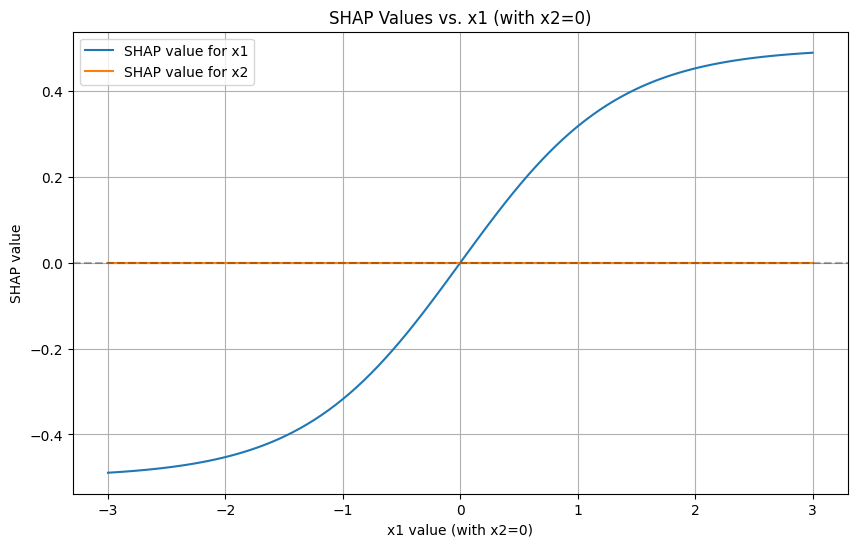

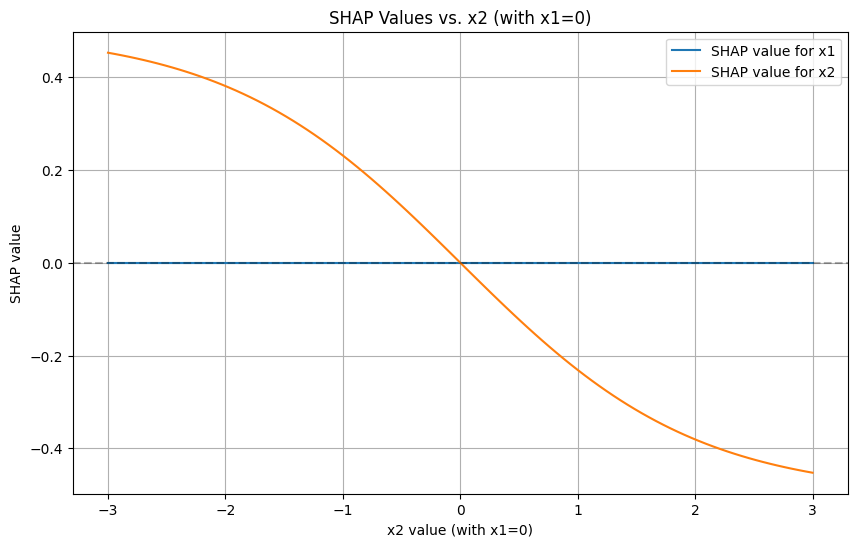

In [8]:
# Calculate SHAP values for instances along the x1 axis (with x2=0)
x1_values = np.linspace(-3, 3, 100)
phi_x1_values = []
phi_x2_values = []

for x1 in x1_values:
    explanation = explainer.explain_instance(x1, 0.0, 0.0, 0.0)
    phi_x1_values.append(explanation["phi_x1"])
    phi_x2_values.append(explanation["phi_x2"])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x1_values, phi_x1_values, label='SHAP value for x1')
plt.plot(x1_values, phi_x2_values, label='SHAP value for x2')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('x1 value (with x2=0)')
plt.ylabel('SHAP value')
plt.title('SHAP Values vs. x1 (with x2=0)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate SHAP values for instances along the x2 axis (with x1=0)
x2_values = np.linspace(-3, 3, 100)
phi_x1_values = []
phi_x2_values = []

for x2 in x2_values:
    explanation = explainer.explain_instance(0.0, x2, 0.0, 0.0)
    phi_x1_values.append(explanation["phi_x1"])
    phi_x2_values.append(explanation["phi_x2"])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x2_values, phi_x1_values, label='SHAP value for x1')
plt.plot(x2_values, phi_x2_values, label='SHAP value for x2')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('x2 value (with x1=0)')
plt.ylabel('SHAP value')
plt.title('SHAP Values vs. x2 (with x1=0)')
plt.legend()
plt.grid(True)
plt.show()


## Experimenting with Different Baselines

The choice of baseline can significantly affect the SHAP values. Let's experiment with different baselines to see how they impact the explanations.


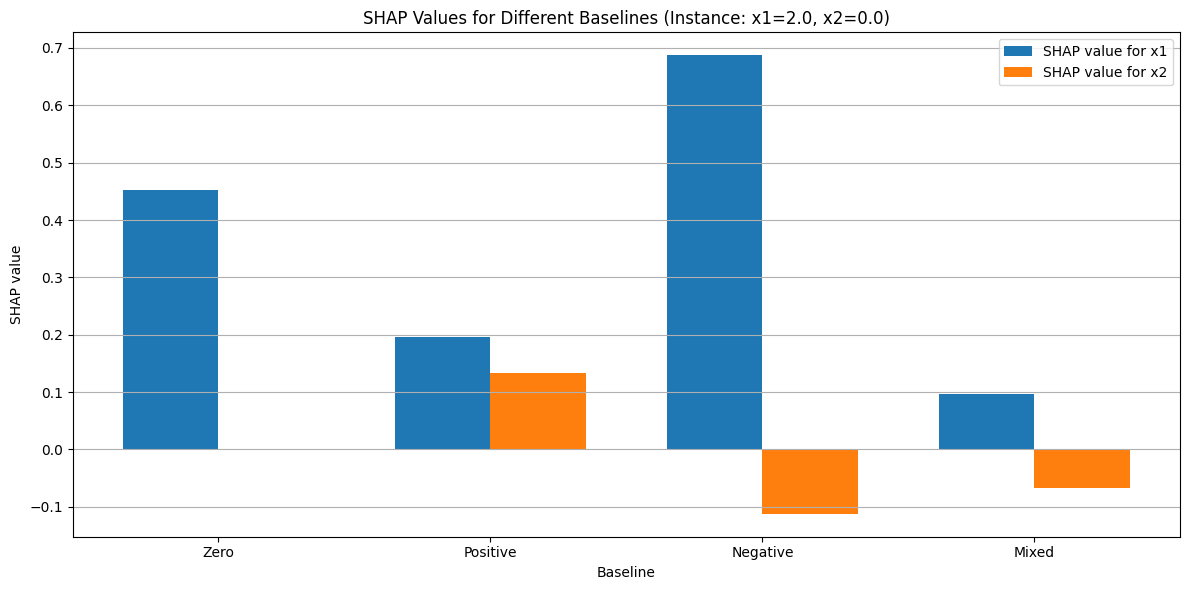

In [9]:
# Define different baselines
baselines = [
    {"name": "Zero", "x1": 0.0, "x2": 0.0},
    {"name": "Positive", "x1": 1.0, "x2": 1.0},
    {"name": "Negative", "x1": -1.0, "x2": -1.0},
    {"name": "Mixed", "x1": 1.0, "x2": -1.0}
]

# Choose an instance to explain
x1_instance, x2_instance = 2.0, 0.0

# Calculate SHAP values for each baseline
results = []
for baseline in baselines:
    explanation = explainer.explain_instance(
        x1_instance, x2_instance,
        baseline["x1"], baseline["x2"]
    )
    results.append({
        "baseline": baseline["name"],
        "f_baseline": explanation["f_baseline"],
        "phi_x1": explanation["phi_x1"],
        "phi_x2": explanation["phi_x2"],
        "f_instance": explanation["f_instance"],
        "check_sum": explanation["check_sum"]
    })

# Create a comparison table
import pandas as pd
results_df = pd.DataFrame(results)
results_df

# Visualize the results
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(baselines))

plt.bar(index, results_df["phi_x1"], bar_width, label='SHAP value for x1')
plt.bar(index + bar_width, results_df["phi_x2"], bar_width, label='SHAP value for x2')

plt.xlabel('Baseline')
plt.ylabel('SHAP value')
plt.title(f'SHAP Values for Different Baselines (Instance: x1={x1_instance}, x2={x2_instance})')
plt.xticks(index + bar_width/2, results_df["baseline"])
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


## Conclusion

In this notebook, we've implemented a simplified version of the SHAP algorithm from scratch and used it to explain predictions from a simple black-box model. We've seen how SHAP works by:

1. Calculating the model's prediction for all possible combinations of features
2. Computing the Shapley values as the weighted average of each feature's marginal contributions
3. Verifying the local accuracy property (baseline + sum of Shapley values = model prediction)

We've also explored:
- How SHAP values change for different instances
- How the choice of baseline affects the explanations
- The relationship between SHAP values and true feature importance

SHAP is a powerful technique for explaining individual predictions of complex machine learning models, making them more transparent and trustworthy. By understanding how SHAP works, we can better interpret and communicate the decisions made by our models.

Key advantages of SHAP:
- **Theoretical Soundness**: Based on solid game theory principles
- **Local Accuracy**: Provides precise explanations for individual predictions
- **Consistency**: Features with larger impacts on the model receive larger SHAP values
- **Additivity**: SHAP values sum to the difference between the model prediction and the baseline

In practice, the full SHAP algorithm can be computationally expensive for models with many features, as it requires evaluating the model for all possible feature subsets (2^n combinations for n features). Various approximation methods exist to make SHAP more practical for complex models with many features.